# Experimental Design
***
## Optimising underlayers

Import the neccesary libraries

In [4]:
%matplotlib inline

import numpy as np
import refnx
from hogben.models.bilayers import Multilayer

from hogben.optimise import Optimiser
from hogben.simulate import simulate
from hogben.utils import Fisher
from refnx.reflect import SLD

import matplotlib.pyplot as plt

def refnx_model():
    """Define a bilayer sample, and return the associated refnx model"""
    # Define sample
    air = SLD(0, name='Air')
    layer2 = SLD(6, name='Layer 2')(thick=25, rough=8)
    layer3 = SLD(3, name='Layer 3')(thick=80, rough=2)
    substrate = SLD(2.047, name='Substrate')(thick=0, rough=2)

    layer2.thick.bounds = (140, 160)
    layer3.thick.bounds = (1, 500)
    layer2.rough.bounds = (1, 3)
    layer3.rough.bounds = (2, 5)
    layer3.underlayer = True

    sample = air  | layer2 | layer3 | substrate
    model = refnx.reflect.ReflectModel(sample, scale=1, bkg=5e-6, dq=2)

    xi = [layer2.rough,
          layer2.thick,
          layer3.thick,
          layer3.rough]
    for param in xi:
        param.vary = True
    return model

model = refnx_model()

Create a new sample:

Optimise



In [5]:
# Number of points and counting times for each angle to simulate.
angle_times = [(0.7, 100, 10),
               (2.3, 100, 40)]
thick_bounds = (1, 150)
sld_bounds = (1, 7)

conditions = {"thick_bounds": thick_bounds,
              "sld_bounds": sld_bounds,
              "angle_times": angle_times}

sample = Multilayer(model)
thicknesses, slds, val = \
    Optimiser.optimise_underlayer_experiment(sample, conditions,
                                             verbose=False)
print(thicknesses)
print(slds)

[22.5895769]
[4.33622493]


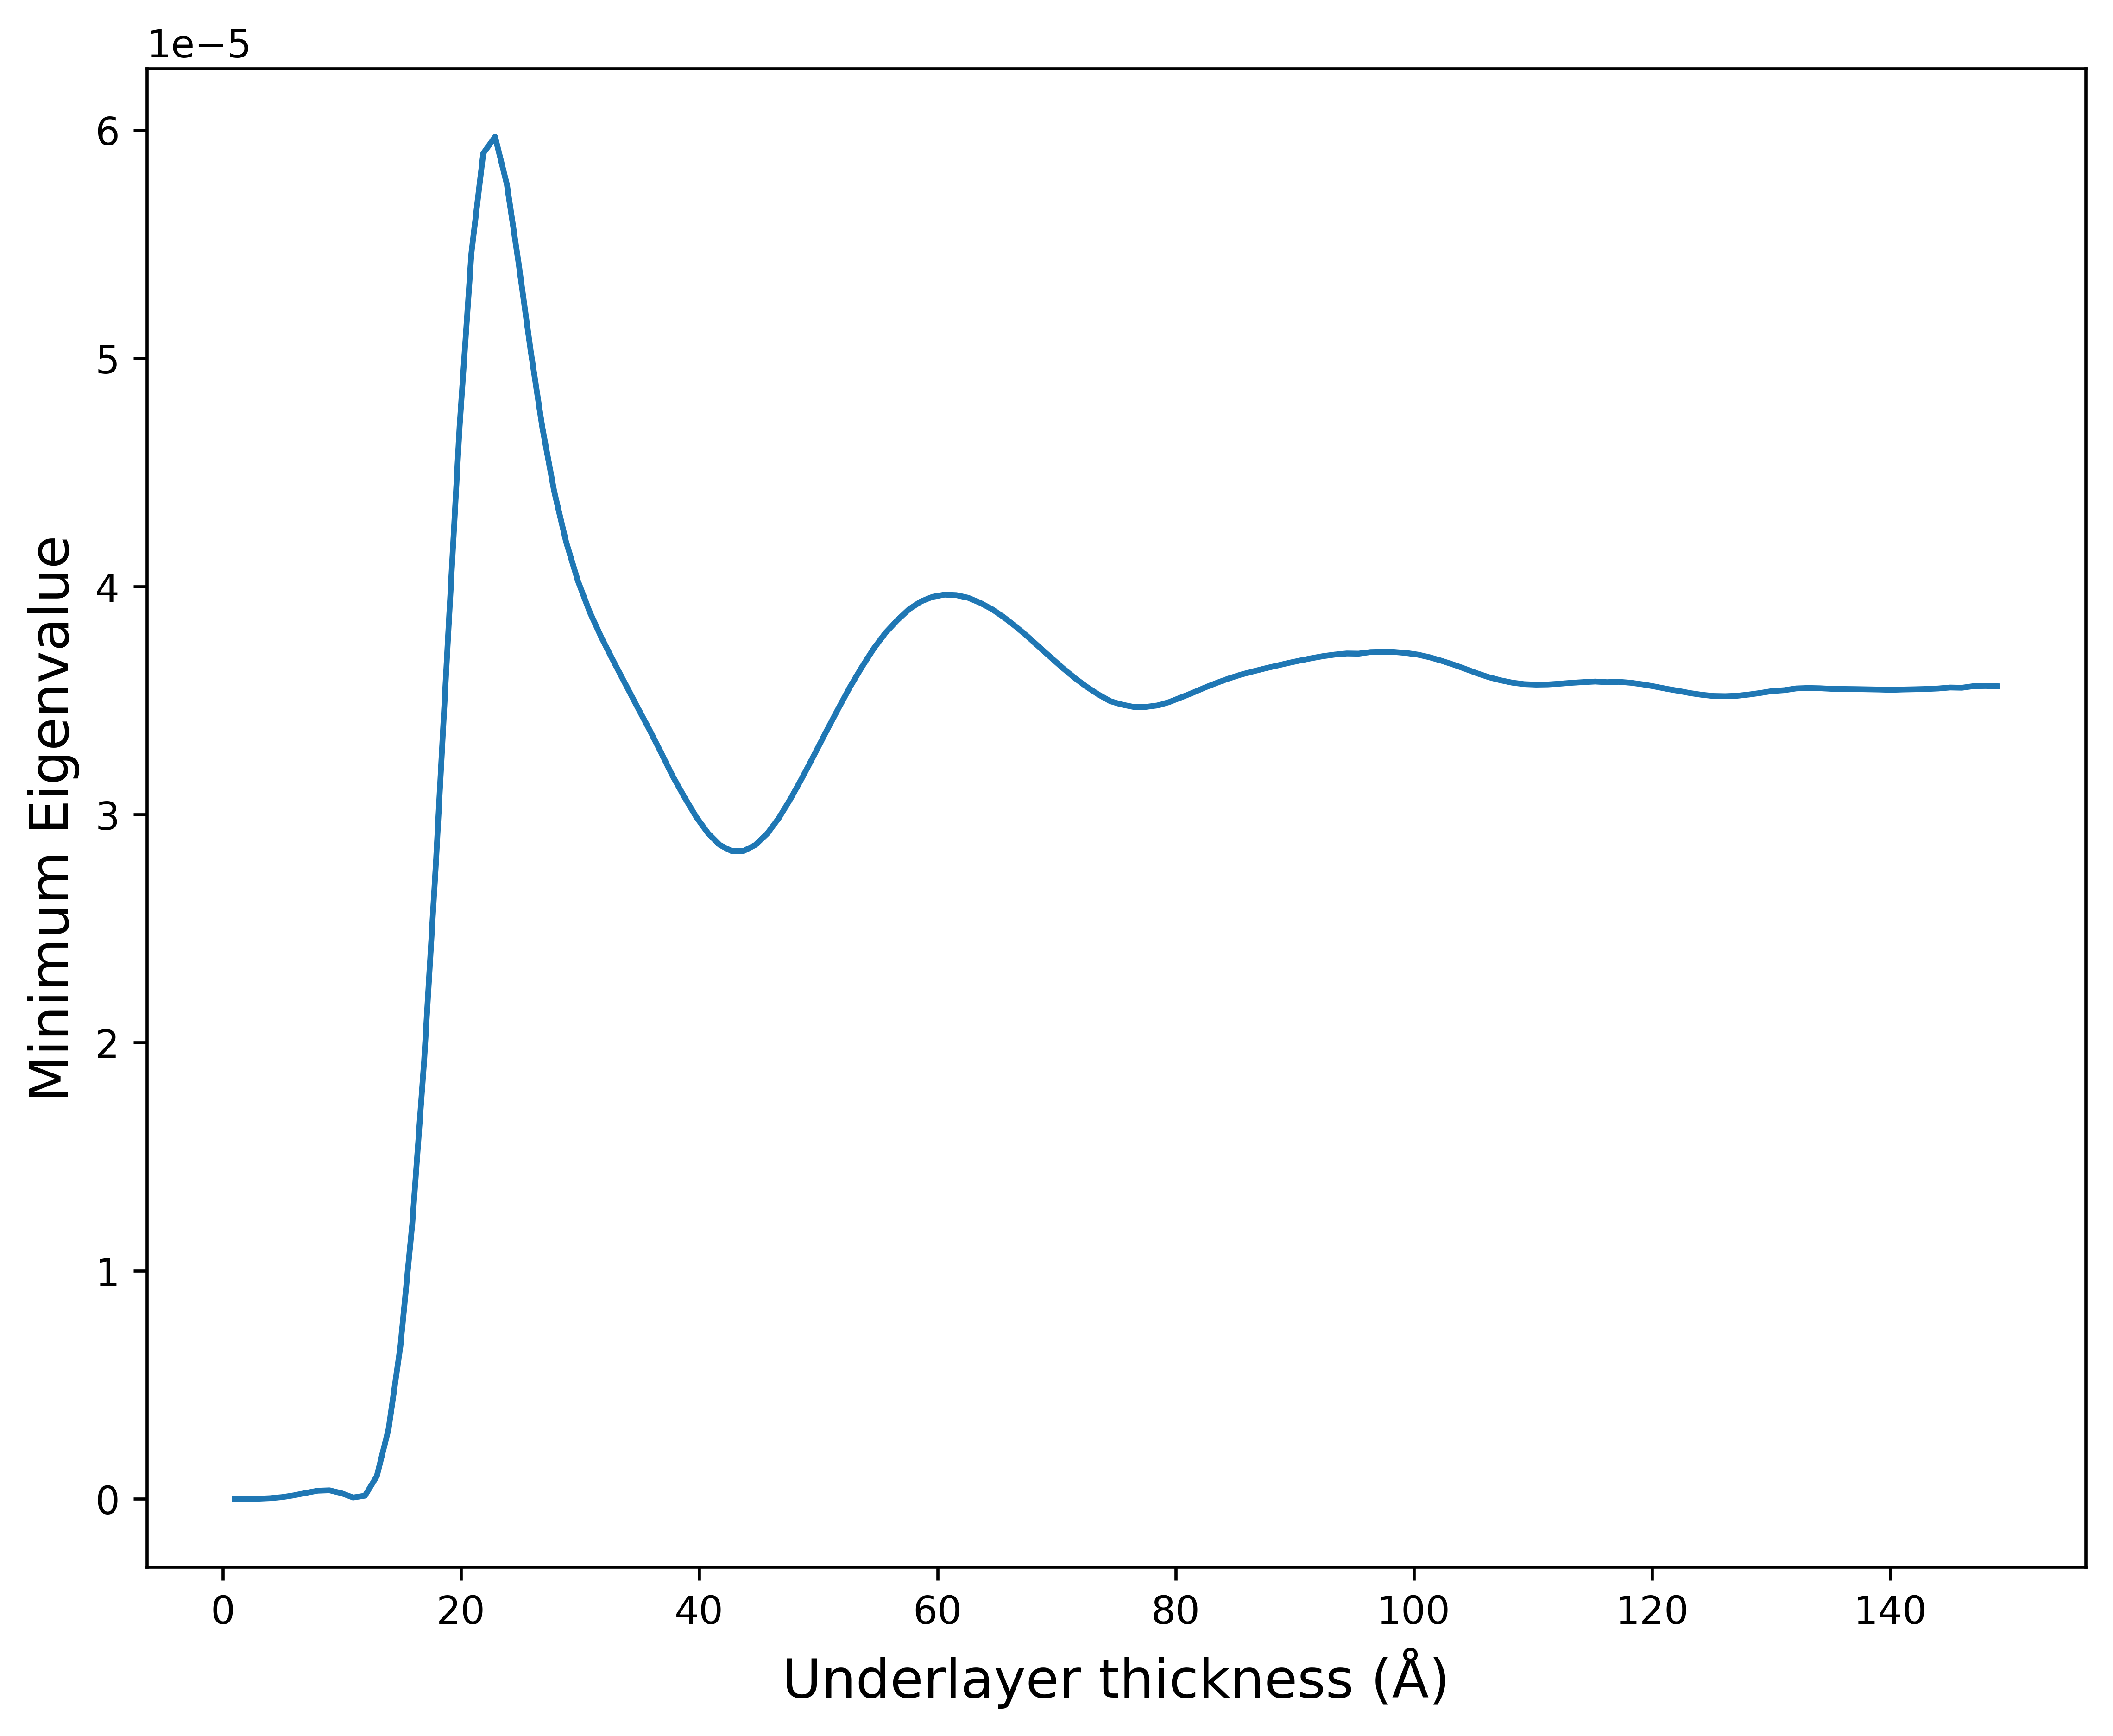

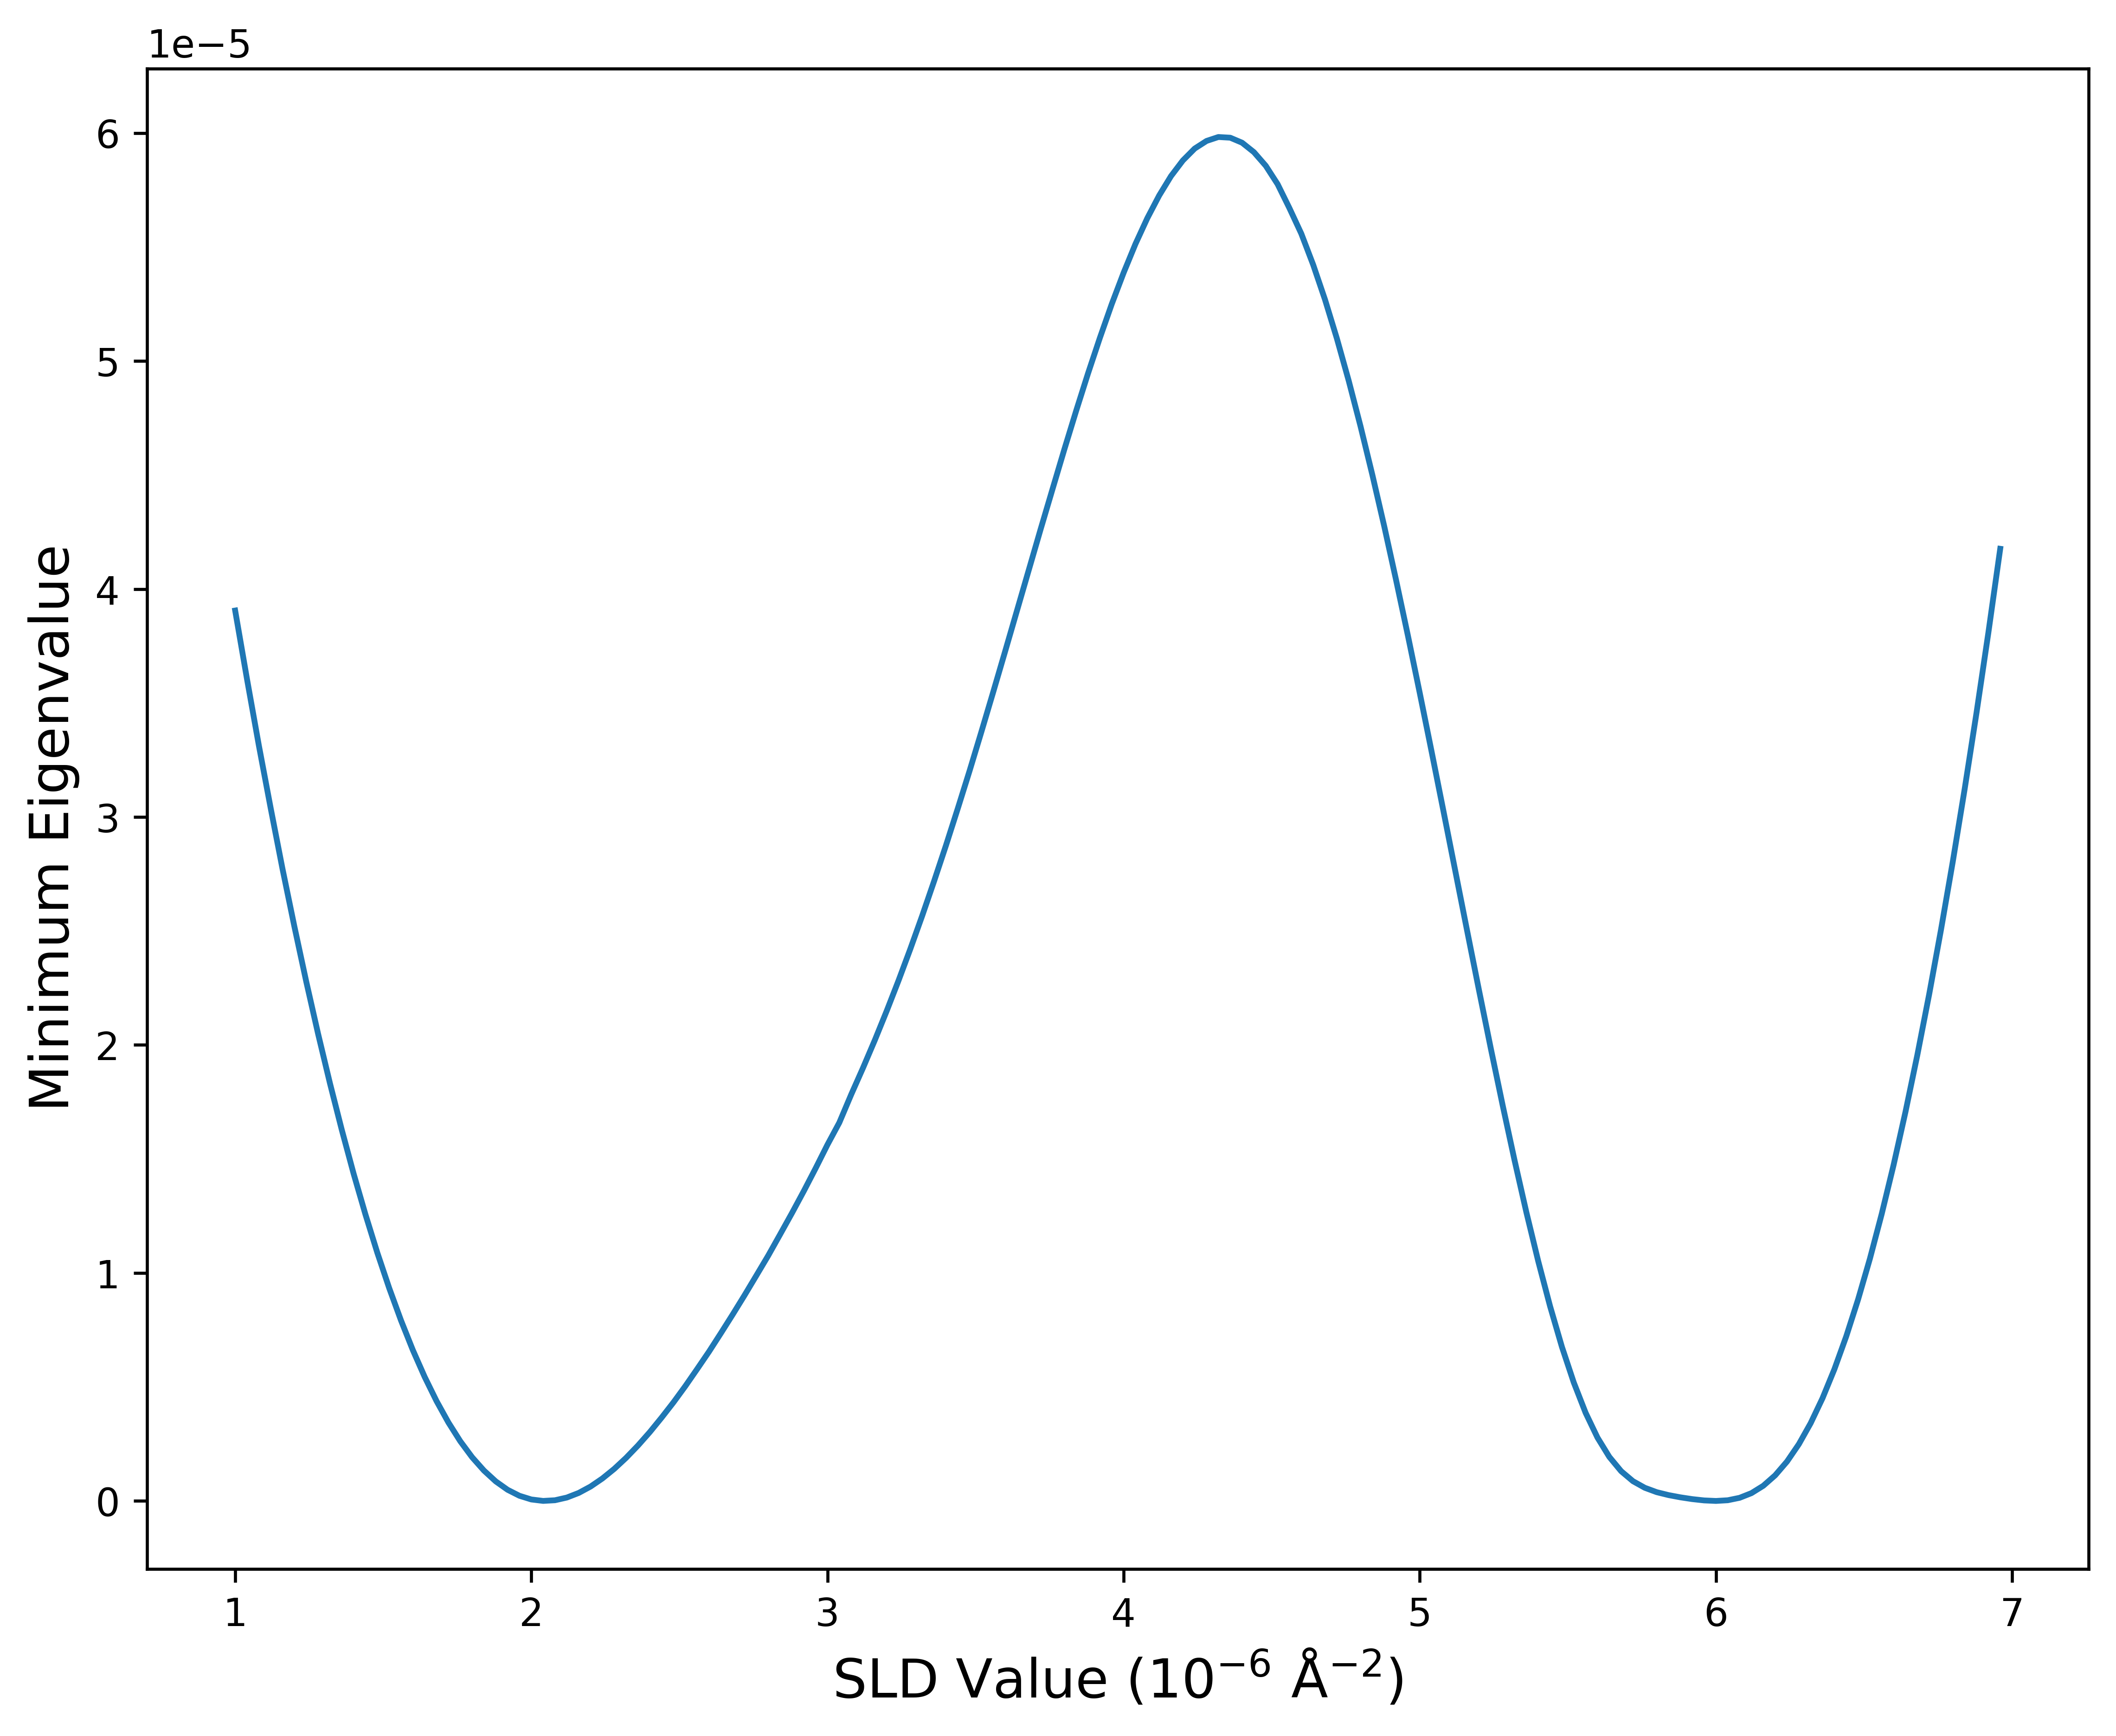

<Figure size 5400x4200 with 0 Axes>

In [6]:

thick_range = thick_bounds[1] - thick_bounds[0]
sld_range = sld_bounds[1] - sld_bounds[0]

eigenval = []
thicknessrange = []

i = 0
for layer in sample.structure:
    if hasattr(layer, 'underlayer') and layer.underlayer:
        layer.thick.value = thicknesses[i]
        layer.sld.real.value = slds[i]

        for j in range(150):
            thick = (thick_range/150)*j + thick_bounds[0]
            thicknessrange.append(thick)
            layer.thick.value = thick
            min_eigenval = Fisher.from_sample(sample, [angle_times]).min_eigenval
            eigenval.append(min_eigenval)
        i += 1


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(thicknessrange, eigenval)
ax.set_xlabel('Underlayer thickness (Å)', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue', fontsize = 14)
plt.show()

eigenval = []
sldarray = []

i = 0
for layer in sample.structure:
    if hasattr(layer, 'underlayer') and layer.underlayer:
        layer.thick.value = thicknesses[i]
        layer.sld.real.value = slds[i]

        for j in range(150):
            sld = (sld_range/150)*j + sld_bounds[0]
            sldarray.append(sld)
            layer.sld.real.value = sld
            min_eigenval = Fisher.from_sample(sample, [angle_times]).min_eigenval
            eigenval.append(min_eigenval)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sldarray, eigenval)
ax.set_xlabel('SLD Value (10$^{-6}$ Å$^{-2})$', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue ', fontsize = 14)
plt.show()
plt.savefig("sld.png")